In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils.vis_utils import plot_model

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Create Dataset with EEG-Data compressed by trained Autoencoder

```python
data, events = dp.load_data()
data, events = dp.choose_condition(data, events, 'inner speech')
norm_data = data.astype(np.float16) * 100_000  # NORMALIZATION ONLY POSSIBLE BY MULTIPLYING HERE?
norm_data = dp.normalization(norm_data)

dataset = tf.data.Dataset.from_tensor_slices((norm_data, events[:, 1]))
dataset = dp.preprocessing_pipeline(
    dataset,
    functions = [dp.filter_interval_tensor,
                 lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 lambda sample: (tf.reshape(sample[0], (128, 640, 1)),
                                 sample[1])],
    args = [[[1, 3.5], 256], [], []],
    batch_size = 12
)

# save dataset so that we can just load the preprocessed version next time
tf.data.experimental.save(dataset, 'dataset/preprocessed/auto_class_ds')
```

In [2]:
# load datasets
datasets = {key:tf.data.experimental.load(f'dataset/preprocessed/new_full_ds/{key}') for key in ('train', 'test', 'valid')}

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-16 13:18:11.136809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 13:18:11.136987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# load dataset created previously
##dataset = tf.data.experimental.load('dataset/preprocessed/auto_class_ds')
# Load autoencoder-model
autoencoder_trained = tf.keras.models.load_model('./models/saved_models/autoencoder_20Epochs_train_split')
# create dataset by extracting latent space for every sample
autoencoded_datasets = {key:models.autoencoder.latent_dataset(autoencoder_trained.encoder, ds) for key, ds in datasets.items()}
##autoencoded_dataset = autoencoded_dataset.shuffle(200)
##autoencoded_datasets = dp.split_dataset(autoencoded_dataset)

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
(32, 40, 3)


2022-03-16 13:18:12.272974: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-16 13:18:12.278494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


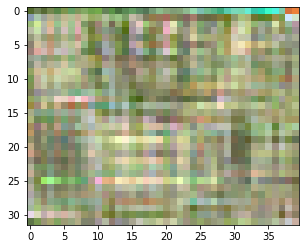

In [4]:
%matplotlib inline
for i, t in autoencoded_datasets['valid'].take(1):
    print(t[0])
    # normalize
    norm_enc = i[0] / np.max(i[0], (0, 1))[np.newaxis, np.newaxis, :]
    plt.imshow(norm_enc)
    print(norm_enc.shape)
    plt.show()

### Classify Autoencoded Dataset

In [5]:
#from models.classifiers import ConvAuto1

#model1 = ConvAuto1()
#model1.build((12, 32, 40, 3))
#model1.summary()

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Normalization, LeakyReLU, Activation, BatchNormalization, MaxPool2D

class ConvAuto2(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(ConvAuto2, self).__init__()

        self.layer_list = [
            tf.keras.layers.GaussianNoise(1),
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.2),
                tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")
            ]),
            Conv2D(filters=64, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            Conv2D(filters=32, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            Conv2D(filters=8, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs, training=None) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active 
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x, training=training)
        return x

model1 = ConvAuto2()
#model1.build((None, 32, 40, 3))
#model1.summary()

model_name = '32_32_8_20Epochs'
#plot_model(model1, to_file=f'./models/saved_models/classifiers/{model_name}_info.png', show_shapes=True, show_layer_names=True, expand_nested=True)


In [7]:
for i, t in autoencoded_datasets['train'].take(1):
    print(tf.shape(t))

tf.Tensor([12  4], shape=(2,), dtype=int32)


2022-03-16 13:18:12.668478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [8]:
%matplotlib tk

# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
trainer = train.Trainer(model1, autoencoded_datasets,
                        optimizer, loss_func, train.accuracy)
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(3,1, supxlabel='Epochs', axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

trainer.model_test()
for epoch in range(20):
    print("Epoch:", epoch, trainer.losses['train'], end='\r')
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test'], trainer.accuracies['test']])

print(trainer.test('valid'))


2022-03-16 13:18:13.092356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:18:13.250120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:18:13.412298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:18:20.141972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-16 13:18:20.253962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-16 13:18:27.177627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


ValueError: Exception encountered when calling layer "conv_auto2" (type ConvAuto2).

in user code:

    File "/var/folders/mt/0n8phlt50rn7h35xhgh97mw80000gn/T/ipykernel_73688/2508993075.py", line 48, in call  *
        x = layer(x, training=training)
    File "/Users/lld/miniforge3/envs/py35/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "random_flip" (type RandomFlip).
    
    tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(12, 32, 40, 3), dtype=float32)
      • training=True


Call arguments received:
  • inputs=tf.Tensor(shape=(12, 32, 40, 3), dtype=float32)
  • training=True

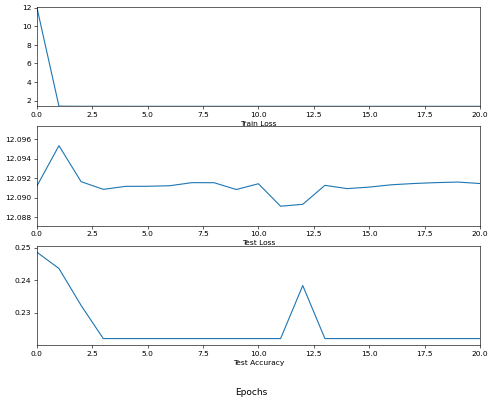

In [ ]:
%matplotlib inline
#rapher.fig.set_size_inches(18.5, 10.5)
grapher.fig

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model1.save(f'./models/saved_models/classifiers/{model_name}')
grapher.fig.savefig(f'./models/saved_models/classifiers/{model_name}_info')

ValueError: Creating variables on a non-first call to a function decorated with tf.function.